In [5]:
from gensim.models import Word2Vec
from w2v_random_forest import W2V_RandomForest
from w2v_kmeans import W2V_KMeans

from datetime import datetime
import re
import time
import numpy as np
import random
import argparse
import duckdb

%matplotlib inline

In [2]:
db_string   = "/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/database/w2v_20240731_test.db"
model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/best/"
output_dir  ='/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/logs/clustering/'

## UTILS

### Get vocab for a model

In [3]:
#
# extracts the words used in a word2vec model by wuerying the model itself
# returns a list of words with any whitespace remoived as well as count of the umber of items
#       
def get_pfam_vocab(model_path, exclude_gaps=False):
    model = Word2Vec.load(model_path)
    
    vocab           = model.wv.key_to_index
    pfam_vocab    = []
    for i, word in enumerate(vocab):
        if exclude_gaps:
            if (word == 'GAP' or word == 'START_GAP' or word == 'STOP_GAP' or word == 'DISORDER'):
                #print('ignoring', word)
                continue
        else:
            word = word.lstrip()
            word = word.rstrip()
            pfam_vocab.append(word)
    return pfam_vocab, len(pfam_vocab)



# Retrieves a subset of vectors from a w2v model dictionary - those being the vectors corresponding to pfam words
# in the dictionary that only have mappings to clans. This subset will be used to train model and see if it can
# accurately predict the labels of a test set
#
def get_model_vectors_clan_only(model_path, min_count, vector_size):
    
    model = Word2Vec.load(model_path)
    # I just happen to know that we will end up with 6,133 words, each with a vector of 25 dimensions
    
    if(min_count == 'mc1'):
        num_rows = 7508
    elif(min_count == 'mc3'):
        num_rows = 6745
    elif(min_count == 'mc5'):
        num_rows = 6419
    elif(min_count == 'mc8'):
        num_rows = 6133
    
    # create matrices and arrays for data
    X           = np.empty((num_rows, vector_size))
    X_pfam_ids  = []
    Y           = []
    
    #print(f"Created matrix X {X.shape}")
    
    full_vocab, num_items = get_pfam_vocab(model_path)
    con = duckdb.connect(database=db_string)
    count = 0
    for pfam_id in full_vocab:
        try:          
            result = con.execute(f"SELECT PFAM_ID, CLAN_ID FROM W2V_PFAM_CLAN WHERE PFAM_ID ='{pfam_id}'").fetchall()
            
            #if(result == []):
            #    print(f"No results for {pfam_id}")
            if(result != []):
                #print(result)
                pfam_result = result[0][0]
                clan_result = result[0][1]
                
                if clan_result != 'undef':
                    #print(f" ----------------- adding {clan_result} for {pfam_result}")
                    X_pfam_ids.append(pfam_result)
                    Y.append(clan_result)
                    X[count,:] = model.wv[pfam_result]
                    count +=1
                #else:
                #    print(f"ignoring {clan_result} for {pfam_result}")
        except Exception as e:
            print('Error', e, pfam_id)
            con.close()
            return
    #print(f"model with mc {min_count} has {count} pfam-clan pairs.")
    con.close()
    
    return X, Y, X_pfam_ids

### Graphing

In [26]:
def graph_2d(X, model_name):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.datasets import make_blobs

    # Generate a random multi-dimensional dataset (e.g., 5 dimensions)
    #X, _ = make_blobs(n_samples=100, n_features=5, centers=3, random_state=42)

    # Apply PCA to reduce it to 2 dimensions
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    comic_font = {'fontname':'Comic Sans MS'}
    helv_font = {'fontname':'Helvetica'}

    # Plot the 2D projection
    plt.figure(figsize=(4, 3))
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c='#069AF3', marker='o', edgecolor='#069AF3', s=10)
    plt.title(f"W2V Model : {model_name} - Principal Components", **helv_font)
    
    # change size of font used for tick marks on axes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # label the axes - using a font
    plt.xlabel("Vocab : PC 1", **helv_font)
    plt.ylabel("Vocab : PC 2", **helv_font)
    
    plt.grid(False)
    plt.show()
    
def graph_3d(X):
    
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from mpl_toolkits.mplot3d import Axes3D

    # Step 1: Create a sample multi-dimensional dataset (e.g., 5D)
    #np.random.seed(42)
    #data = np.random.rand(100, 5)  # 100 points in 5D space

    # Step 2: Apply PCA to reduce to 3D
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(X)

    # Step 3: Plot the reduced data in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the 3D projection
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c='blue', marker='o')

    # Label axes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Show plot
    plt.show()

## DEFINE MODELS & GET VOCAB VECTORS

### Graph the vectors in a model vocab

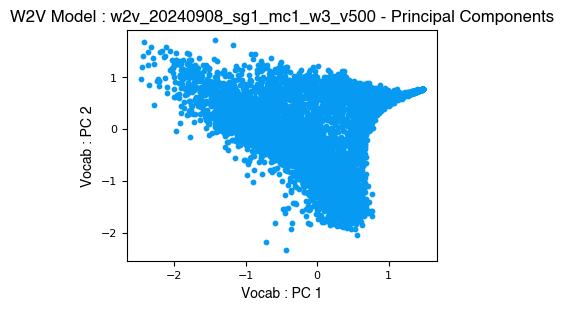

In [34]:
#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/all_models_final/skip_mc8/"
#model_names=['w2v_20240901_sg1_mc8_w8_v5', 'w2v_20240901_sg1_mc8_w8_v10', 'w2v_20240901_sg1_mc8_w8_v25', 'w2v_20240901_sg1_mc8_w8_v50', 'w2v_20240901_sg1_mc8_w8_v75', 'w2v_20240901_sg1_mc8_w8_v100']

#model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']

model_dir   ="/Users/patrick/dev/ucl/word2vec/COMP_0158_MSC_PROJECT/data/models/"
#model_names = ['w2v_20240908_sg1_mc1_w3_v250']
model_names = ['w2v_20240908_sg1_mc1_w3_v500']

for model_name in model_names:

    model_path = model_dir+model_name+'.model'
    min_count_s = re.search("(mc[0-9]+)_", model_name)
    min_count = min_count_s.group(1)
    vector_s = re.search("v([0-9]+)", model_name)
    vector_size = vector_s.group(1)

    # get vocab for model
    #vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=False)
    vocab, vocab_count = get_pfam_vocab(model_path, exclude_gaps=True)
    
    X, Y, pfam_ids = get_model_vectors_clan_only(model_path, min_count, int(vector_size))
    
    graph_2d(X, model_name)

#### Graph the models

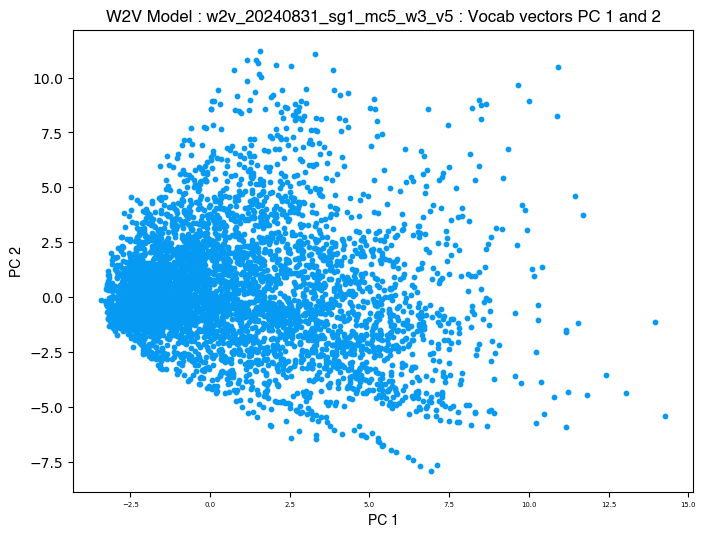

In [19]:
graph_2d(X, model_name)